In [265]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from ml_utils import graph

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [266]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:55]].min()

In [291]:
out_dir = '../../papi_output/'
path = out_dir + 'o17l.csv'

df = pd.read_csv(path, error_bad_lines=False)
df = aggregate(df)

df = df.loc[df['time'] > 0]

#for col in df.columns[:52]:
#    df[col] = df[col].apply(lambda q: np.log(q) if q>0 else 0)

cols = sorted(list(df.columns.values))
df = df[cols]

X = df.iloc[:,:52].as_matrix()
scalerx = StandardScaler()
X = scalerx.fit_transform(X)

y = df.iloc[:,52].as_matrix().reshape(-1, 1)

pca = PCA(n_components=2)
pca.fit(X)
x2 = pca.transform(X)
#x2=X

X_train = x2[:18000]
X_test = x2[18000:]
y_train = y[:18000]
y_test = y[18000:]

print(df.shape)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/maciej/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(20038, 53)


In [292]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
  return model

model = build_model()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_56 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [293]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

# Store training stats
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[PrintDot(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])



..........

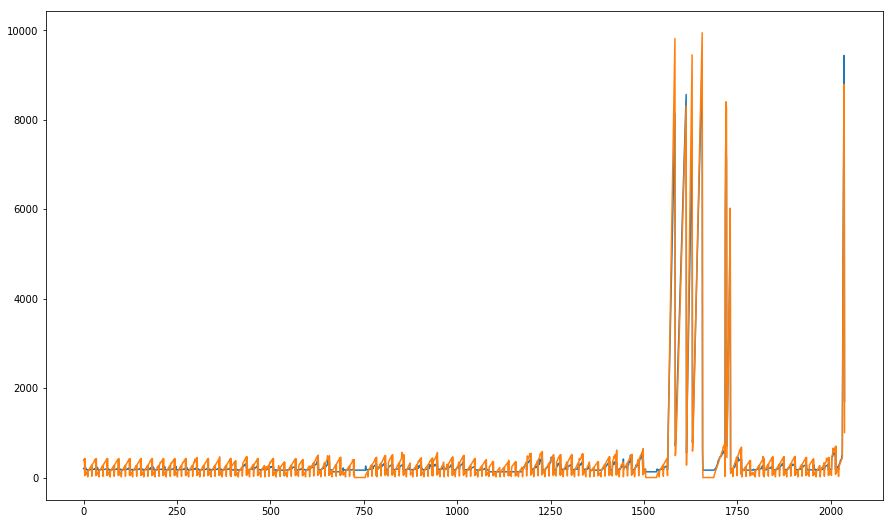

In [294]:
def plot_history(y_test, pred, model):
    plt.figure()
    plt.plot(pred)
    plt.plot(y_test)

pred = model.predict(X_test)
plot_history(y_test, pred, model)

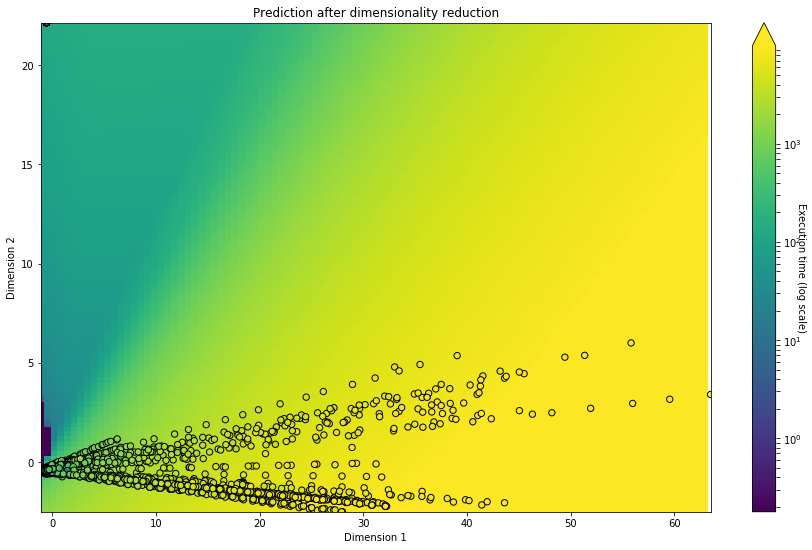

In [295]:
graph(model, x2, y.flatten())

In [296]:
r2_score(y_test, pred)

0.9768662969437262